<a href="https://colab.research.google.com/github/DJCordhose/mlops-drift/blob/main/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training, Re-Train on new data, re-engineer training

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/buch-machine-learning-notebooks/raw/main/kap11/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'./datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

In [3]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

2023-11-03 11:06:09.530242: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 11:06:09.597334: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 11:06:09.990415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 11:06:09.990581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 11:06:09.991265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

'2.14.0'

In [4]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [5]:
tf.random.set_seed(42)

In [6]:
import numpy as np
np.__version__

'1.26.1'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [8]:
if IN_COLAB:
    !pip install -q lrcurve

In [9]:
# https://github.com/AndreasMadsen/python-lrcurve
from lrcurve import KerasLearningCurve

# Step 1: Choosing data set to train on

In [10]:
use_new_data_for_training = False
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show

In [11]:
import pandas as pd

if not use_new_data_for_training:
  # original (old) data
  df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
else:
  # new data
  df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')

In [12]:
df.head()

,training,age,emergency_braking,braking_distance,power,milage,risk,group_name,group,good_customer
0,0,41.951100,0,40.933328,122.238329,98.509765,3.705528,high,0,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.442419,medium,1,0
2,0,18.314649,1,41.587241,143.427269,76.862968,4.074379,high,0,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.093286,high,0,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.733844,high,0,0


In [13]:
df.describe()

,training,age,emergency_braking,braking_distance,power,milage,risk,group,good_customer
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.182905,0.902000,0.436667
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481600,0.815377,0.496138
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.283898,0.000000,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.711191,0.000000,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.388913,1.000000,0.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874870,2.000000,1.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.348509,2.000000,1.000000


# Step 2: Preparing data

In [14]:
# comment in or even add more dropped features

def drop_unimportant_features(df):
    # in the future we will only see samples with emergency braking
    # df = df[df['emergency_braking'] == 1]
    # drop features that no longer have a significant impact on prediction to avoid overfitting
    # df.drop(['emergency_braking'], axis='columns', inplace=True)
    return df


In [15]:
df = drop_unimportant_features(df)
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'milage', 'risk', 'group_name', 'group', 'good_customer'],
      dtype='object')

In [16]:
df.describe()

,training,age,emergency_braking,braking_distance,power,milage,risk,group,good_customer
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.182905,0.902000,0.436667
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481600,0.815377,0.496138
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.283898,0.000000,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.711191,0.000000,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.388913,1.000000,0.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874870,2.000000,1.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.348509,2.000000,1.000000


In [17]:
binary_classifications = True

In [18]:
if binary_classifications:
    y = df['good_customer'].values  # binary classification
else:
    y = df['group'].values  # categorical classification
# y = df['risk'].values  # regression

np.unique(y, return_counts=True)

(array([0, 1]), array([845, 655]))

In [19]:
df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns', inplace=True)

In [20]:
df = df.round(1)
df.head(10)

,training,age,emergency_braking,braking_distance,power,milage
0,0,42.0,0,40.9,122.2,98.5
1,0,24.4,1,44.8,113.8,46.3
2,0,18.3,1,41.6,143.4,76.9
3,0,51.3,1,47.3,111.6,102.7
4,0,23.6,0,42.8,146.0,63.7
5,0,29.5,1,46.5,139.8,66.6
6,0,21.3,1,40.7,134.7,63.1
7,1,47.5,0,35.2,142.2,123.4
8,1,20.6,1,41.8,114.7,103.9
9,0,24.6,1,40.8,162.5,44.3


In [21]:

from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

# Step 3a: Establishing baseline for categories

In [22]:
LOW_RISK = 2
MEDIUM_RISK = 1
HIGH_RISK = 0

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [23]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
base_clf = RandomClassifier()    
base_clf.score(X_test, y_test)

0.33666666666666667

In [24]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1]), array([676, 524]))

In [25]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return HIGH_RISK
base_clf = NaiveClassifier()    
base_clf.score(X_test, y_test)

0.5633333333333334

In [26]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, milage = x
#         print(age, power, milage)
        if training: 
            return LOW_RISK
        if age < 30:
            if power > 130:
                return HIGH_RISK
            else:
                return MEDIUM_RISK
        if age > 50:
            return HIGH_RISK
        if emergency_braking:
            return LOW_RISK
        if milage > 50:
            return HIGH_RISK
        if milage > 30:
            return MEDIUM_RISK
        # default
        return LOW_RISK
base_clf = BaseLineClassifier() 
base_clf.score(X_test, y_test)

0.41333333333333333

# Step 3b: Baseline for binary classifier

In [27]:
class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [28]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(0, 2)
base_clf = RandomClassifier()    
base_clf.score(X_test, y_test)

0.47333333333333333

In [29]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1]), array([676, 524]))

In [30]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return 0
base_clf = NaiveClassifier()    
base_clf.score(X_test, y_test)

0.5633333333333334

In [31]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, milage = x
        if training: 
            return 1
        if age < 30:
            if power > 100:
                return 0
        if age > 55:
            return 0
        if emergency_braking:
            return 1
        if milage > 50:
            return 0
        # default
        return 0
base_clf = BaseLineClassifier() 
base_clf.score(X_test, y_test)

0.7733333333333333

# Step 4: Training Keras model

In [32]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
# takes mean and variance from X_train for normalization
normalizer.adapt(X_train)

In [33]:
# this output and output from next cell are the same
X_train.mean(axis=0), X_train.var(axis=0)

(array([  0.21083333,  35.20791667,   0.39916667,  39.95533333,
        135.62941667,  80.86933333]),
 array([1.66382639e-01, 1.67871012e+02, 2.39832639e-01, 2.31307882e+01,
        1.22778484e+03, 6.37994843e+02]))

In [34]:
normalizer.mean, normalizer.variance

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[  0.21083328,  35.207924  ,   0.39916658,  39.955334  ,
         135.6294    ,  80.869354  ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[1.6638267e-01, 1.6787103e+02, 2.3983261e-01, 2.3130787e+01,
         1.2277850e+03, 6.3799475e+02]], dtype=float32)>)

In [35]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation


num_features = X.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# model.add(Dense(neurons_per_layer, name='hidden3'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

if binary_classifications:
    model.add(Dense(name='output', units=1, activation='sigmoid'))
else:
    model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

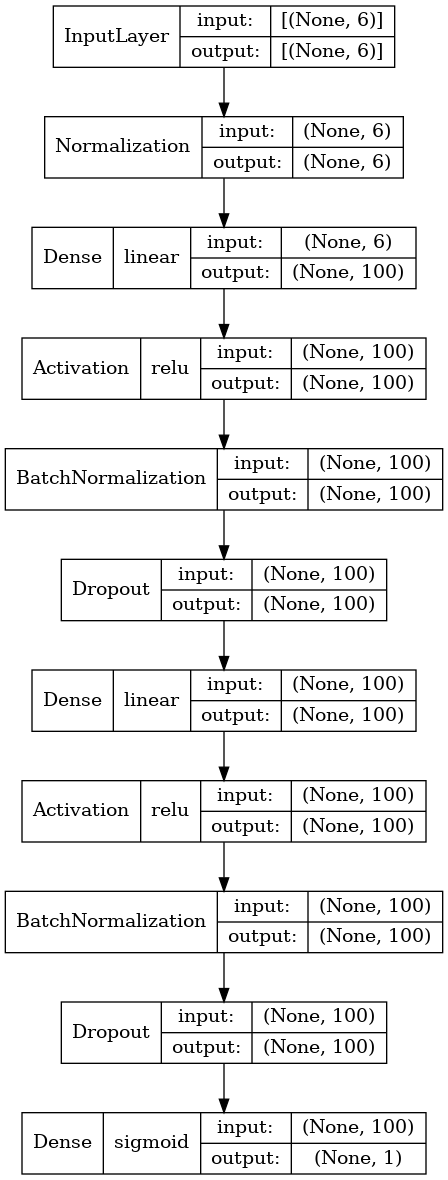

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [37]:
%%time

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 75

if binary_classifications:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'

model.compile(loss=loss,
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    # validation_data=(X_test, y_test),
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 12.1 s, sys: 2.38 s, total: 14.5 s
Wall time: 12.3 s


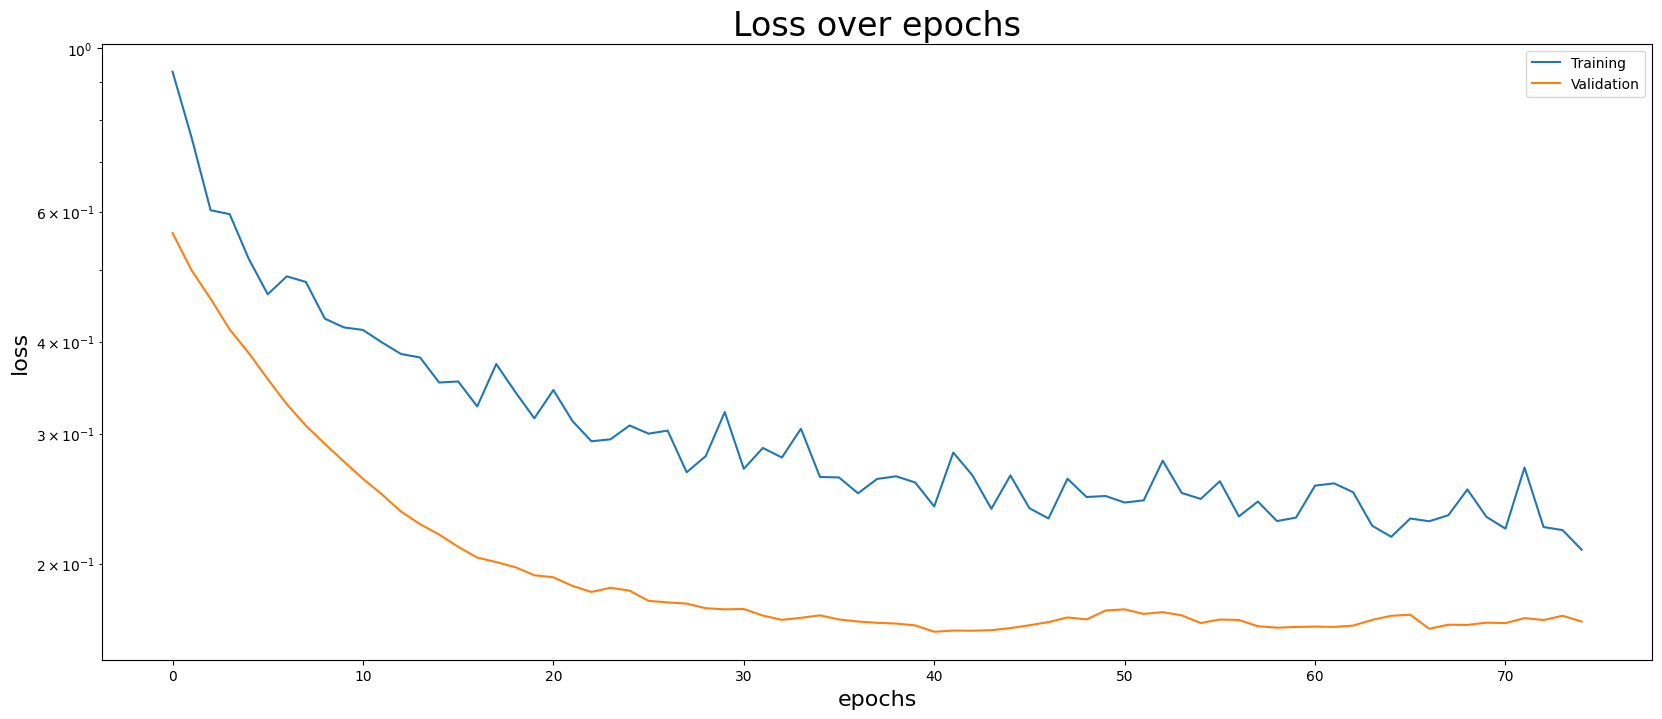

In [38]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

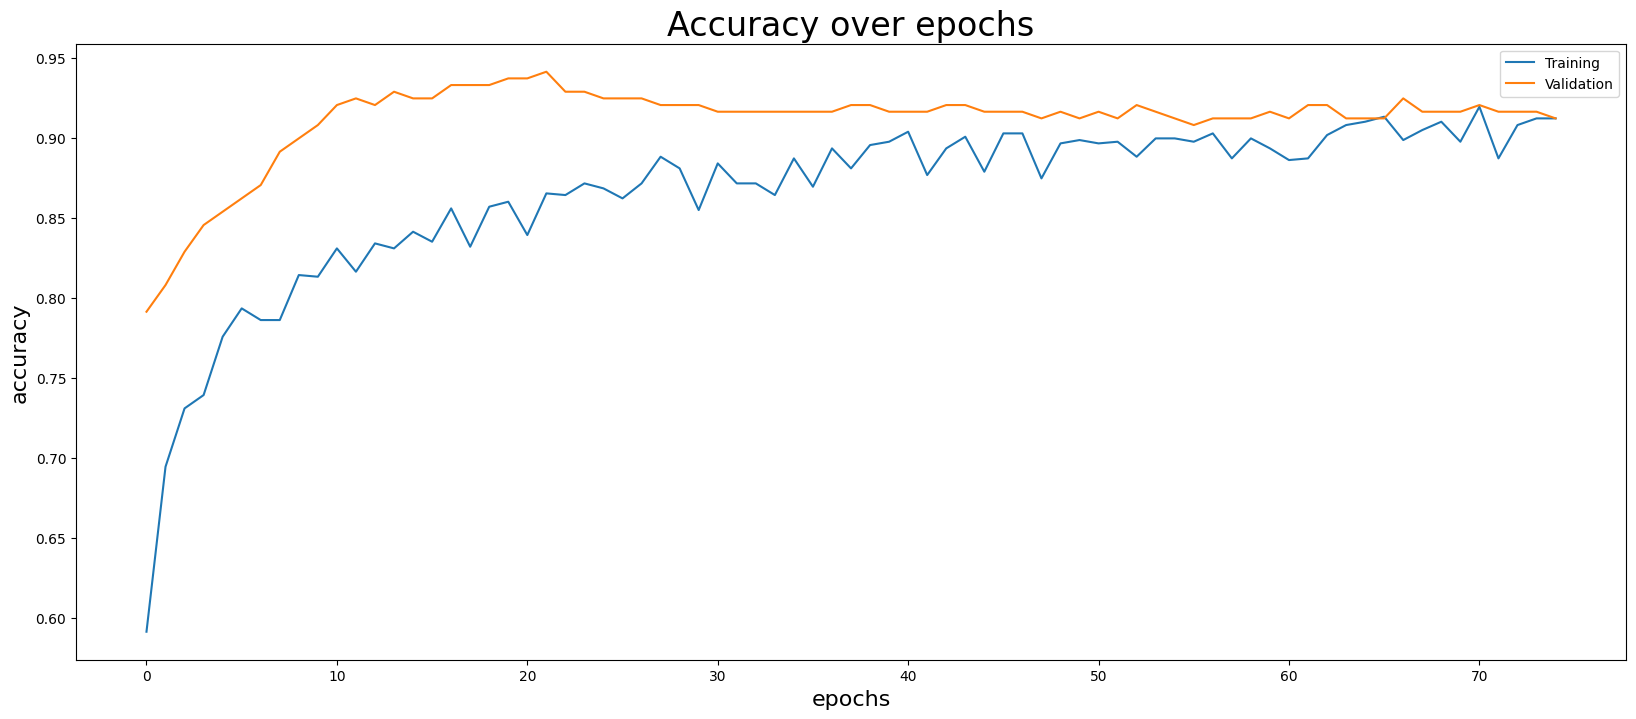

In [39]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

In [40]:
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final validation accuracy: {val_accuracy * 100:.2f}%")
val_loss, val_accuracy

Final validation accuracy: 91.25%


(0.167083278298378, 0.9125000238418579)

In [41]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 3ms/step - loss: 0.1458 - accuracy: 0.9392


(0.14578472077846527, 0.9391666650772095)

In [42]:
test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.9200


(0.19995111227035522, 0.9200000166893005)

# Step 5: Choosing data set for evaluation

In [43]:
use_new_data_for_evaluation = False
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show

In [44]:
import pandas as pd

if not use_new_data_for_evaluation:
  # original (old) data
  df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
else:
  # new data
  df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')


In [45]:
df = drop_unimportant_features(df)
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'milage', 'risk', 'group_name', 'group', 'good_customer'],
      dtype='object')

In [46]:
if binary_classifications:
    y = df['good_customer'].values  # binary classification
else:
    y = df['group'].values  # categorical classification
# y = df['risk'].values  # regression

np.unique(y, return_counts=True)

(array([0, 1]), array([845, 655]))

In [47]:
df = df.round(1)
df.head()

,training,age,emergency_braking,braking_distance,power,milage,risk,group_name,group,good_customer
0,0,42.0,0,40.9,122.2,98.5,3.7,high,0,0
1,0,24.4,1,44.8,113.8,46.3,2.4,medium,1,0
2,0,18.3,1,41.6,143.4,76.9,4.1,high,0,0
3,0,51.3,1,47.3,111.6,102.7,5.1,high,0,0
4,0,23.6,0,42.8,146.0,63.7,3.7,high,0,0


In [48]:
X = df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns').values

In [49]:
from sklearn.model_selection import train_test_split
# FIXME: does not make sense when this is a completely new dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

In [50]:
_, train_metric = model.evaluate(X_train, y_train, verbose=0)
train_metric

0.9391666650772095

In [51]:
_, test_metric = model.evaluate(X_test, y_test, verbose=0)
test_metric

0.9200000166893005

# Step 6: Check Invariant Properties of Model

## Accuracy range and lack of overfitting

In [52]:
# 85% is sufficient for our use case
assert train_metric > .85

In [53]:
assert test_metric > .85

In [54]:
assert abs(train_metric - test_metric) < .05

In [55]:
# we can not be too good, this would be a suspicious

assert test_metric < .95
assert train_metric < .95

## Distribution of Output Class

In [56]:
if not binary_classifications:
    y_pred = model.predict(X).argmax(axis=1)
else:
    threshold = .5
    y_pred = (model.predict(X) > threshold).astype("int32")
y_pred.shape

47/47 [==============================] - 0s 3ms/step


(1500, 1)

In [57]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

(array([0, 1], dtype=int32), array([828, 672]))

In [58]:
# equal distribution around classes expected
tolerance = 0.25
expected_count = len(X) / len(values)
lower_bound = int(expected_count * (1 - tolerance))
upper_bound = int(expected_count * (1 + tolerance))
print(f'{lower_bound}-{upper_bound}')

for count in counts:
    print(count)
    assert count in range(lower_bound, upper_bound)

600-900
828
672


## Invariants of the model itself
Could be
* effective depth of tree (if decision tree has been used as architecture instead of NN)
* distribution of weights
* actual normalization
* probabilty distribution

**We do not use these properties as we want to treat the model as a black box to make it interchangable**

# Step 7: Calculating Business KPI (Key Performance Indicator)

https://en.wikipedia.org/wiki/Precision_and_recall

1. **True Positive (tp)**: The number of cases where the classifier correctly predicted that a customer should be given a loan or insurance (i.e., the customer was a good risk and the classifier said 'yes').

2. **False Positive (fp)**: The number of cases where the classifier incorrectly predicted that a customer should be given a loan or insurance (i.e., the customer was actually a bad risk, but the classifier said 'yes'). This is costly as it represents a loss to the company due to potentially not recovering the loan or having to pay out insurance claims.

3. **True Negative (tn)**: The number of cases where the classifier correctly predicted that a customer should not be given a loan or insurance (i.e., the customer was a bad risk and the classifier said 'no').

4. **False Negative (fn)**: The number of cases where the classifier incorrectly predicted that a customer should not be given a loan or insurance (i.e., the customer was actually a good risk, but the classifier said 'no'). This represents a lost opportunity where the company misses out on business from a good customer.

When applying the financial impacts to these outcomes:

- **True Positives** would generate a benefit of \$1,000 each, because these are customers who were correctly identified as good risks, leading to profitable business.
- **False Positives** would cost \$5,000 each, because these are instances where the business is lost due to non-payment or claims that outweigh premiums.
- **False Negatives** would cost \$1,000 each, representing the lost profit from a good customer who was incorrectly turned away.
- **True Negatives** does not generate direct revenue (since no loan or insurance policy is issued), it does have a positive financial impact by avoiding potential costs, however, it's more challenging to assign a direct monetary value, so we do not consider it here

The goal is to maximize the number of true positives while minimizing the number of false positives and false negatives, balancing the risk and opportunity to ensure profitability.

In [59]:
y_true = y_test
if not binary_classifications:
    y_pred = model.predict(X_test).argmax(axis=1)
else:
    threshold = .5
    y_pred = (model.predict(X_test) > threshold).astype("int32")
y_true.shape, y_pred.shape


10/10 [==============================] - 0s 2ms/step


((300,), (300, 1))

In [60]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(156, 13, 11, 120)

In [61]:
# costs and benefits
cost_fp = 5_000  # cost of a false positive
reward_tp = 1000  # reward of a true positive
cost_fn = 1000  # cost of a false negative

kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
kpi_per_case = round(kpi  / len(y_true))

print(f"KPI: ${kpi_per_case}")


KPI: $147


In [70]:
# kpi depends on where we make the split between good and bad customers
def kpi_for_threshold(X, y_true, threshold):
    y_pred = (model.predict(X, verbose=0) > threshold).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
    kpi_per_case = round(kpi  / len(y_true))
    return kpi_per_case, (tn, fp, fn, tp)

In [71]:
kpi_for_threshold(X_test, y_test, threshold=.5)

(147, (156, 13, 11, 120))

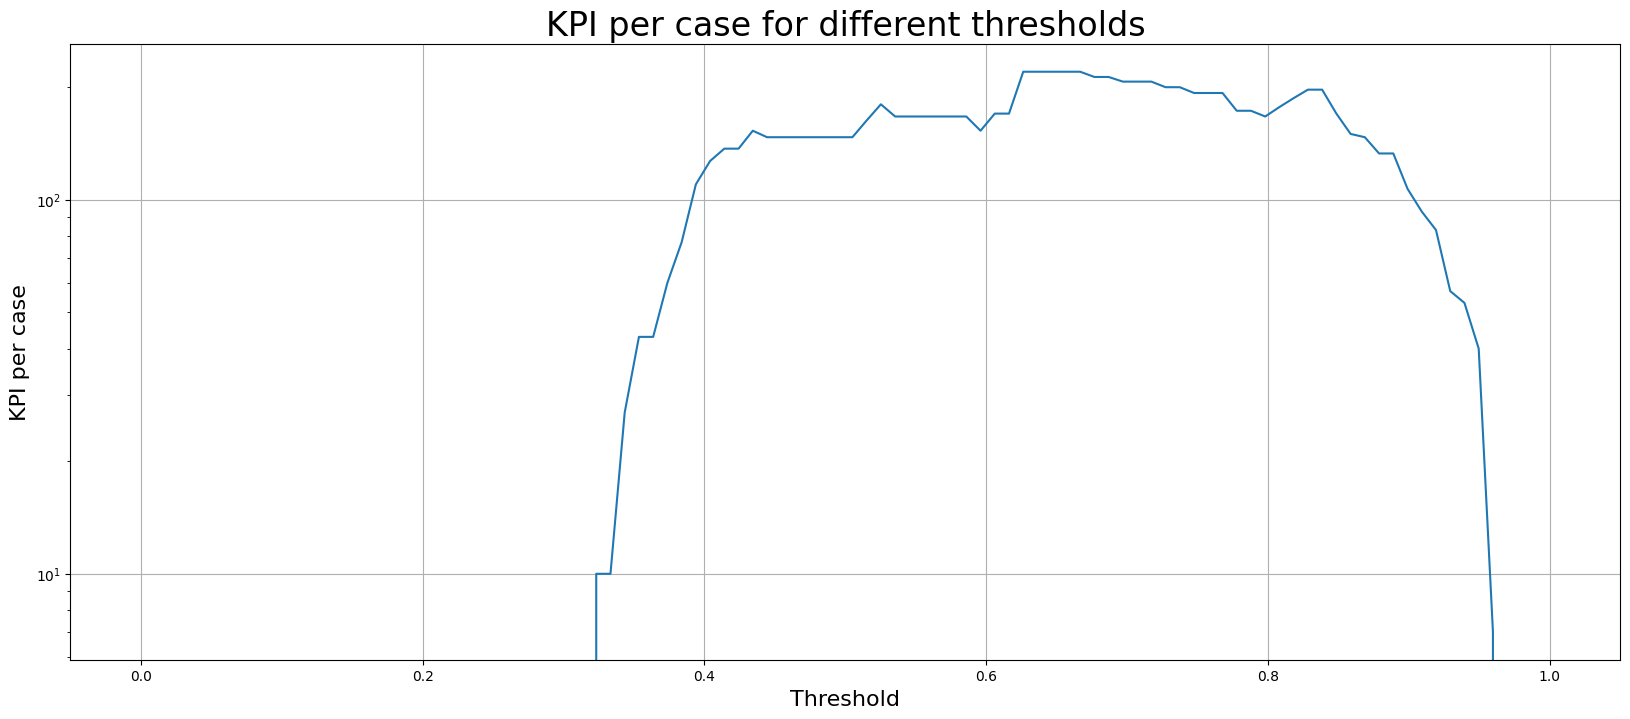

In [72]:
thresholds = np.linspace(0, 1, 100)
kpi_values = []

# Calculate KPI for each threshold
for threshold in thresholds:
    kpi, _ = kpi_for_threshold(X_test, y_test, threshold)
    kpi_values.append(kpi)

# Plotting the results
plt.plot(thresholds, kpi_values)
plt.xlabel('Threshold')
plt.ylabel('KPI per case')
plt.yscale('log')
plt.title('KPI per case for different thresholds')
plt.grid(True)
plt.show()


In [74]:
best_kpi = max(kpi_values)
best_threshold = thresholds[np.array(kpi_values).argmax()]
_, (tn, fp, fn, tp) = kpi_for_threshold(X_test, y_test, best_threshold)
print(f"Best KPI ${best_kpi} for threshold {best_threshold}")
tn, fp, fn, tp

Best KPI $220 for threshold 0.6262626262626263


(162, 7, 15, 116)

## Business tells us that the whole case only makes sense above a certain expeced profit per case and certain percentage of people getting insurance

In our case this is 
* 150$ profit per case
* and at least 1/3 of people getting insurance

In [ ]:
assert best_kpi > 150

In [78]:
rate_people_getting_insurance = (tp + fp) / len(y_test)
rate_people_getting_insurance

0.41

In [80]:
assert rate_people_getting_insurance > 1/3

## Caveats / Room for improvement
1. Estimated benefits and costs are mostly pretty random
1. KPI might be calculated over actually insured people rather than on bases of every case
1. We should consider maximizing profit vs minimizing risk
   * we should plot probabilities (0..1 of final layer) of prediction as histogram
   * probabilities are not calibrated, should do so using additional holdout set (count true/false per bin as proba and compare to predicted)
   * the higher the threshold, the more people we give insurance to, the lower rate of false negative, the higher the risk of false positive
   * add tn, fp, fn, tp to plot of KPI
1. Alternative: use the lowest risk that brings us over required profit per customer   
1. Compare to rule system as baseline, when we have to fall back to baseline, would we still be able to survive? At least make no loss?   
1. One could argue that the benefit for a good customer is much less, namely the amount of money saved by using manual labor
   * this however assumes that a human would make less mistakes, which is debatable at the very least
   * often there are no reliable numbers on the the missed or wrong cases decided by humans
   * in that scenario, even true negatives have a benefit as no human had to touch the case
1. Analyze who are the people with low risk, target those likely to get insurance in big numbers

# Step 8: Saving Model when validation holds

In [67]:
if binary_classifications:
    model.save('classifier-binary.keras', save_format='keras')
else:
    model.save('classifier.keras', save_format='keras')

In [68]:
if binary_classifications:
    model.save('classifier-binary', save_format='tf')
    !tar czvf classifier-binary.tgz ./classifier-binary
else:
    !tar czvf classifier.tgz ./classifier

INFO:tensorflow:Assets written to: classifier-binary/assets


INFO:tensorflow:Assets written to: classifier-binary/assets


./classifier-binary/
./classifier-binary/saved_model.pb
./classifier-binary/variables/
./classifier-binary/variables/variables.index
./classifier-binary/variables/variables.data-00000-of-00001
./classifier-binary/assets/
./classifier-binary/fingerprint.pb
./classifier-binary/keras_metadata.pb


In [69]:
!ls -l

total 12180
-rw-r--r-- 1 olli olli 11073591 Nov  2 16:53 analysis.ipynb
drwxr-xr-x 4 olli olli     4096 Nov  2 10:49 classifier
drwxr-xr-x 4 olli olli     4096 Nov  3 11:06 classifier-binary
-rw-r--r-- 1 olli olli   185946 Nov  3 11:06 classifier-binary.keras
-rw-r--r-- 1 olli olli   162342 Nov  3 11:06 classifier-binary.tgz
drwxr-xr-x 3 olli olli     4096 Nov  1 14:26 datasets
-rw-r--r-- 1 olli olli    49523 Nov  2 17:28 drift-detection.ipynb
-rw-r--r-- 1 olli olli    67487 Nov  3 11:06 model.png
-rw-r--r-- 1 olli olli   907235 Nov  3 11:06 train.ipynb
